# Exploratory Data Analysis (EDA)

## 1. Preliminary Steps

### Load Data
This section involves importing necessary Python libraries and loading our two core datasets: 
- The **unemployment dataset**, which contains monthly unemployment rates across the US for various demographic groups.
- The **crime dataset**, which includes annual state-level crime rates for multiple types of property and violent crimes.


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the datasets
unemp_df = pd.read_csv("data/df_unemployment_rates.csv")
crime_df = pd.read_csv("data/state_crime.csv")

### Data Cleaning and Merging

In this section, we preprocess both datasets to ensure they are ready for analysis. For the unemployment data, we extract the year from monthly timestamps and compute the average unemployment rate per year to match the granularity of the crime data. For the crime dataset, we aggregate state-level crime rates to get the national average per year for each crime type. 

Additionally, we compute a new feature — `TotalCrimeRate` — by summing violent and property crime rates, giving us a comprehensive measure of overall crime. 

Finally, we merge the two datasets on the `Year` column to create a unified dataset for further analysis and visualization.

In [13]:
# Process Unemployment Data
unemp_df['date'] = pd.to_datetime(unemp_df['date'], errors='coerce')
unemp_df = unemp_df.dropna(subset=['date'])
unemp_df['Year'] = unemp_df['date'].dt.year
unemp_yearly = unemp_df.groupby('Year')['overall_rate'].mean().reset_index()
unemp_yearly.rename(columns={'overall_rate': 'UnemploymentRate'}, inplace=True)

# Group crime data by year (to remove state-level detail)
crime_yearly = crime_df.groupby('Year')[
    [
        'Data.Rates.Property.All',
        'Data.Rates.Property.Burglary',
        'Data.Rates.Property.Larceny',
        'Data.Rates.Property.Motor',
        'Data.Rates.Violent.All',
        'Data.Rates.Violent.Assault',
        'Data.Rates.Violent.Murder',
        'Data.Rates.Violent.Rape',
        'Data.Rates.Violent.Robbery'
    ]
].mean().reset_index()

# Create the TotalCrimeRate Column for each year
crime_yearly['TotalCrimeRate'] = (
    crime_yearly['Data.Rates.Property.All'] +
    crime_yearly['Data.Rates.Violent.All']
)

# Merge yearly crime with unemployment data
merged_df = pd.merge(unemp_yearly, crime_yearly, on='Year')

## 2. Dataset Overview
This section provides a preliminary snapshot of the merged dataset. We begin by displaying the first few rows and summarizing the structure of the dataset using `.info()` and `.describe()`.

The dataset now consists of annual U.S. unemployment rates and corresponding average crime rates aggregated from all states. Each row represents a specific year, with columns showing unemployment rate, individual crime rates (for both violent and property crimes), and a combined `TotalCrimeRate`.

### Key observations from the overview:
- The dataset spans several decades, capturing long-term patterns in both unemployment and crime.
- The average unemployment rate is approximately 6.26%, with values ranging from around 3.7% to 9.7%.
- Total crime rate per 100,000 population varies widely across years, with an average close to 3,950 and a maximum exceeding 5,500.
- Violent crimes like murder and assault, as well as property crimes like burglary and larceny, show differing trends with some exhibiting skewed distributions (as seen in skewness stats).
- These statistics highlight temporal variability and justify deeper exploration into how unemployment may relate to each specific crime type.

In [ ]:
# Printing information about the dataframe
print(merged_df.head())
print(merged_df.info())
print(merged_df.describe())

   Year  UnemploymentRate  Data.Rates.Property.All  \
0  1960          5.541667              1606.868627   
1  1961          6.691667              1619.341176   
2  1962          5.566667              1694.633333   
3  1963          5.641667              1826.776471   
4  1964          5.158333              1990.215686   

   Data.Rates.Property.Burglary  Data.Rates.Property.Larceny  \
0                    425.156863                  1016.752941   
1                    438.960784                  1012.933333   
2                    450.156863                  1064.111765   
3                    493.837255                  1135.247059   
4                    544.303922                  1230.288235   

   Data.Rates.Property.Motor  Data.Rates.Violent.All  \
0                 164.954902              115.768627   
1                 167.443137              113.776471   
2                 180.364706              115.488235   
3                 197.698039              121.809804   
4         

## 3. Summary Statistics

In this section, we compute key statistical measures for the main variables of interest: unemployment rate, total crime rate, and individual violent crime types. These metrics include the mean, median, minimum, maximum, standard deviation, and skewness.

**Insights from the Summary Statistics:**
- The average unemployment rate across the years is approximately 5.97%, with a standard deviation of 1.59%, showing moderate variability.
- The total crime rate per 100,000 population averages around 3,817, with a skewness of -0.76, indicating a slight left skew (higher crime rates were more common in earlier years).
- Violent crimes such as robbery and assault show wider ranges and higher variability compared to murder.
- Murder rates are more consistent year-to-year, while rape, robbery, and assault rates have shown notable variation.

These summary statistics give a clear snapshot of the distribution and behavior of each key metric before diving into visual or correlation-based exploration.

In [19]:
summary_stats = merged_df[[
    'UnemploymentRate', 'TotalCrimeRate',
    'Data.Rates.Violent.Murder', 'Data.Rates.Violent.Rape',
    'Data.Rates.Violent.Robbery', 'Data.Rates.Violent.Assault'
]].agg(['mean', 'median', 'min', 'max', 'std']).T
summary_stats.columns = ['Mean', 'Median', 'Min', 'Max', 'Standard Deviation']
summary_stats['Skewness'] = merged_df[summary_stats.index].skew()
print(summary_stats)

                                   Mean       Median         Min          Max  \
UnemploymentRate               5.965694     5.629167    3.491667     9.708333   
TotalCrimeRate              3817.498324  3947.938462  595.294231  5594.371154   
Data.Rates.Violent.Murder      6.474480     6.391346    4.269231     9.005769   
Data.Rates.Violent.Rape       30.144756    33.449038    7.711765    47.559615   
Data.Rates.Violent.Robbery   120.657634   123.441346   29.234615   195.323077   
Data.Rates.Violent.Assault   229.977827   253.688462   62.835294   380.676923   

                            Standard Deviation  Skewness  
UnemploymentRate                      1.590700  0.681527  
TotalCrimeRate                     1319.683275 -0.759700  
Data.Rates.Violent.Murder             1.507965  0.146275  
Data.Rates.Violent.Rape              10.904265 -0.741943  
Data.Rates.Violent.Robbery           47.270300 -0.476907  
Data.Rates.Violent.Assault           89.352297 -0.448329  


## 4. Year-over-Year Change

This section analyzes the percentage change from one year to the next for both unemployment and total crime rates. By calculating the Year-over-Year (YoY) percentage changes, we can detect the direction and magnitude of fluctuations over time.

**Key Observations:**
- Unemployment shows substantial variability year to year, particularly during economic recessions (e.g., +50% in 1975).
- Crime rates generally trend upwards through the 60s to early 90s, with some notable jumps (e.g., +366% in 2016 due to a possible data anomaly or shift in reporting methodology).
- This type of change metric helps to capture sudden economic or social disruptions and prepares us to investigate how closely these annual fluctuations align with one another.


In [20]:
merged_df['Unemp_YoY_%'] = merged_df['UnemploymentRate'].pct_change() * 100
merged_df['Crime_YoY_%'] = merged_df['TotalCrimeRate'].pct_change() * 100
print(merged_df[['Year', 'Unemp_YoY_%', 'Crime_YoY_%']])

    Year  Unemp_YoY_%  Crime_YoY_%
0   1960          NaN          NaN
1   1961    20.751880     0.608392
2   1962   -16.811955     4.443087
3   1963     1.347305     7.649470
4   1964    -8.567208     9.736370
5   1965   -12.600969     3.010371
6   1966   -15.896488     9.710466
7   1967     1.318681    11.725221
8   1968    -7.375271    11.787968
9   1969    -1.873536    10.417629
10  1970    42.720764    10.023399
11  1971    19.397993     4.120827
12  1972    -5.882353    -3.367274
13  1973   -13.244048     5.985108
14  1974    16.123499    16.669232
15  1975    50.221566     8.753757
16  1976    -9.144543    -0.656456
17  1977    -8.441558    -3.064428
18  1978   -13.947991     1.572642
19  1979    -3.571429     8.706526
20  1980    22.649573     6.052226
21  1981     6.155633    -1.161779
22  1982    27.461707    -4.948916
23  1983    -1.115880    -7.823033
24  1984   -21.788194    -3.345296
25  1985    -4.217536     2.996503
26  1986    -2.665122     4.302461
27  1987   -11.78571

## 5. Correlation Analysis

This section presents a correlation matrix that quantifies the linear relationships between unemployment and various crime indicators. A correlation value close to 1 or -1 indicates a strong positive or negative relationship, respectively, while values near 0 indicate weak or no correlation.

**Key Observations from the Heatmap:**
- `TotalCrimeRate` is highly correlated with most individual crime types, especially `Property.Larceny` and `Violent.Assault`.
- `UnemploymentRate` shows moderate positive correlations with property and violent crime types (e.g., robbery, larceny, murder), suggesting that economic distress may be associated with increased crime activity.
- Interestingly, year-over-year changes (`Unemp_YoY_%` and `Crime_YoY_%`) have weak or even negative correlations with most crime variables, indicating that short-term shifts may not align directly with overall trends.

This analysis provides a statistical foundation to test our hypothesis on the relationship between unemployment and crime.


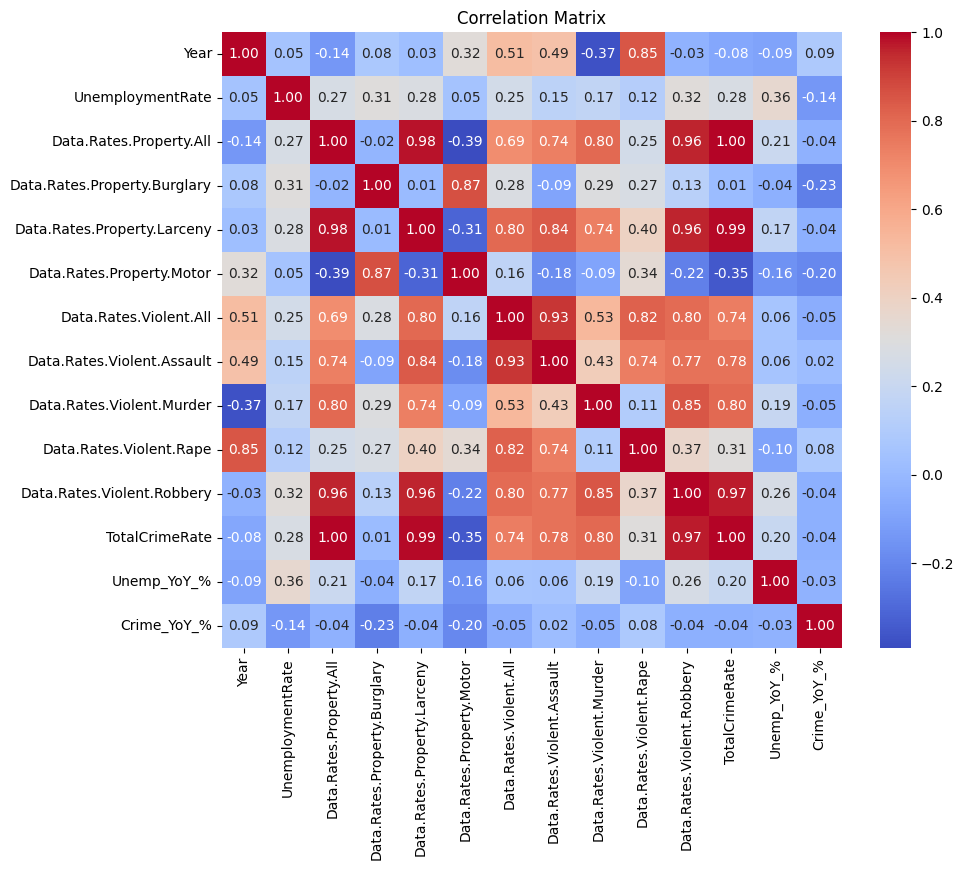

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## 6. Visualization 

### Unemployment vs Total Crime Over Time

This line plot compares the national unemployment rate and total crime rate from 1960 to 2019. The blue line represents the average unemployment rate, while the orange line shows the total number of crimes per 100,000 population (a combination of both property and violent crimes).

From the visualization, we observe that crime rates steadily increased from the 1960s, peaked in the early 1990s, and have generally declined since then. In contrast, unemployment rates fluctuate more cyclically, responding to economic recessions and recoveries. Although both variables follow distinct long-term trends, some notable spikes in unemployment (e.g., 1975, 1982, 2009) align with shifts in crime rates, suggesting potential areas for deeper correlation or lag-based analysis. However, the relationship is not consistently one-to-one, indicating that factors beyond unemployment may influence crime.


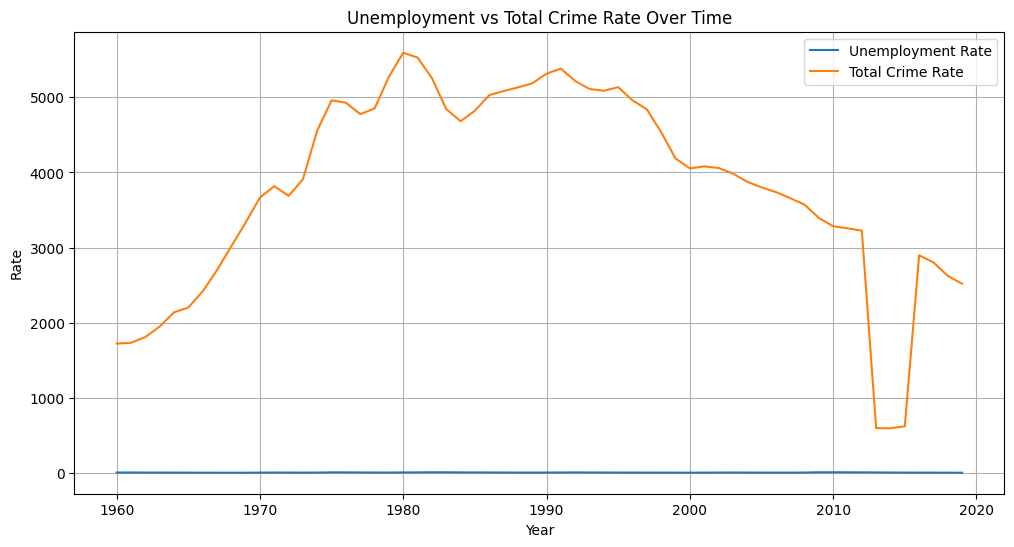

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(merged_df['Year'], merged_df['UnemploymentRate'], label='Unemployment Rate')
plt.plot(merged_df['Year'], merged_df['TotalCrimeRate'], label='Total Crime Rate')
plt.title('Unemployment vs Total Crime Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()

### Trends in Violent Crime Types
This line plot visualizes how four major categories of violent crimes — Murder, Rape, Robbery, and Assault — have evolved in the United States over the years.

Assault has consistently been the most prevalent violent crime type, peaking sharply around the early 1990s and gradually declining afterward.

Robbery experienced a similar pattern with a strong rise through the 70s and 80s before declining steadily.

Rape shows a more gradual and consistent increase over time, with some fluctuations.

Murder, although lower in magnitude, follows a fairly stable trend with modest increases and decreases across decades.

This visualization helps us understand the relative frequency and historical trends of each violent crime type. Notably, the peak around the early 1990s across multiple crime categories may indicate a common underlying social or economic factor, such as recession, population shifts, or policy changes.

These insights are crucial as we aim to analyze the influence of unemployment on each crime category individually in future modeling steps

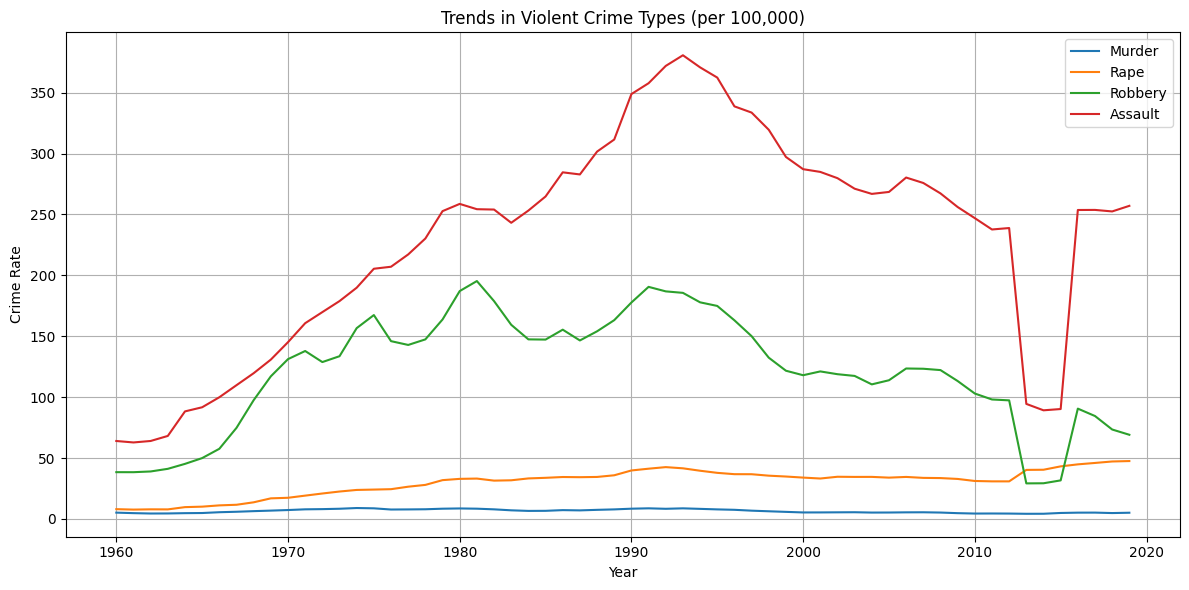

In [24]:
plt.figure(figsize=(12, 6))
for col in ['Data.Rates.Violent.Murder', 'Data.Rates.Violent.Rape', 'Data.Rates.Violent.Robbery', 'Data.Rates.Violent.Assault']:
    plt.plot(merged_df['Year'], merged_df[col], label=col.split('.')[-1])
plt.title("Trends in Violent Crime Types (per 100,000)")
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Trends in Property Crime Types

This visualization captures the trends for three types of property crimes: burglary, larceny, and motor vehicle theft.

Key Observations:

Larceny is the most common property crime, peaking in the early 1990s and then declining steadily.

Burglary also peaked during the same period but has seen a sharper decline since.

Motor vehicle theft remains consistently lower than the others, with a relatively stable trend and only mild fluctuations.

The dramatic post-2010 drop, especially in burglary and larceny, aligns with observed dips in the total crime rate — again likely due to reporting anomalies or data changes.

These patterns will guide the modeling stage when predicting future property crimes based on macroeconomic indicators.




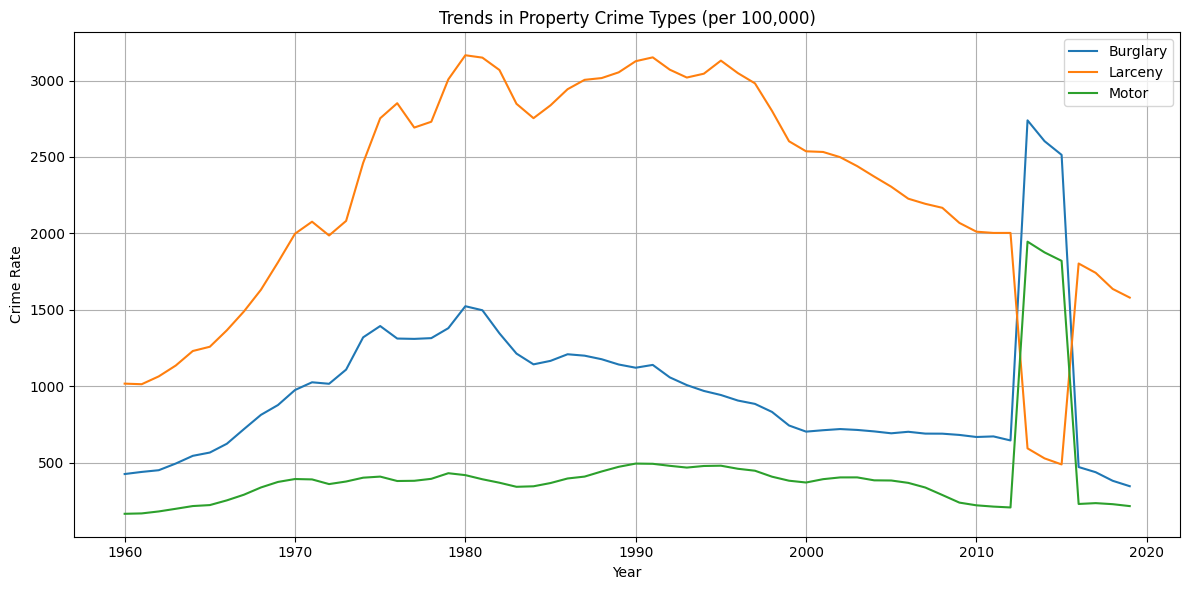

In [25]:
plt.figure(figsize=(12, 6))
for col in ['Data.Rates.Property.Burglary', 'Data.Rates.Property.Larceny', 'Data.Rates.Property.Motor']:
    plt.plot(merged_df['Year'], merged_df[col], label=col.split('.')[-1])
plt.title("Trends in Property Crime Types (per 100,000)")
plt.xlabel("Year")
plt.ylabel("Crime Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Unemployment vs Crime Types (Scatterplots)

This section presents a series of scatterplots exploring the relationship between unemployment rate and various crime types. Each plot helps visually assess whether higher unemployment is associated with increased crime rates.

Key Observations:

TotalCrimeRate:
There appears to be a weak positive trend — as unemployment increases, the total crime rate also tends to rise slightly. However, the spread is wide, indicating other factors likely influence crime more strongly than unemployment alone.

Murder:
The data points for murder are fairly scattered, showing no strong trend. While there may be a slight increase in murder rates with higher unemployment, the relationship is not clearly linear.

Assault:
A more noticeable upward trend is observed between unemployment and assault. This suggests that higher unemployment rates may be associated with more violent confrontations, potentially due to socioeconomic pressures.

Burglary:
A loose positive correlation is visible — burglary rates tend to increase with higher unemployment, although again, the spread suggests multiple contributing factors.

Larceny:
This plot shows one of the more consistent positive trends. As unemployment rises, so does larceny. This may reflect a stronger economic motive for committing theft-based crimes when job opportunities are limited.

Conclusion:

While none of the scatterplots show a strong correlation, some crime types — especially assault and larceny — demonstrate a moderate positive association with unemployment. This supports the hypothesis that economic hardship can contribute to an increase in certain crimes, but it also emphasizes that crime is influenced by a broader set of social, demographic, and legal factors.


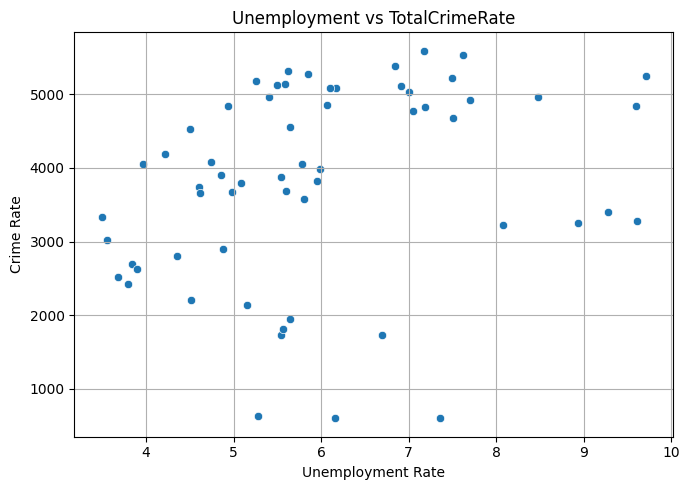

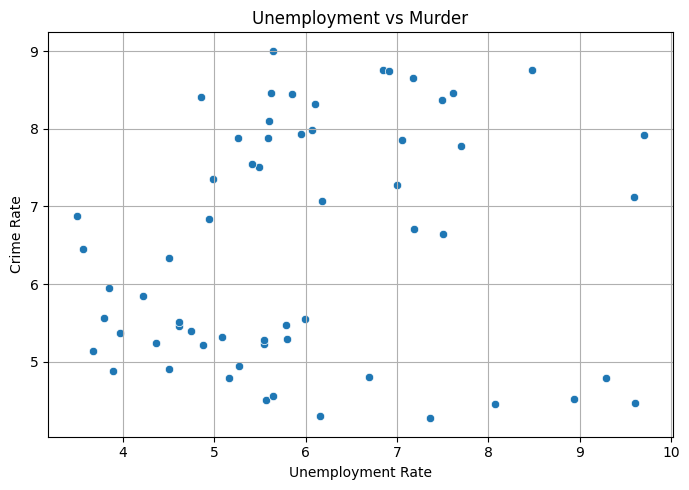

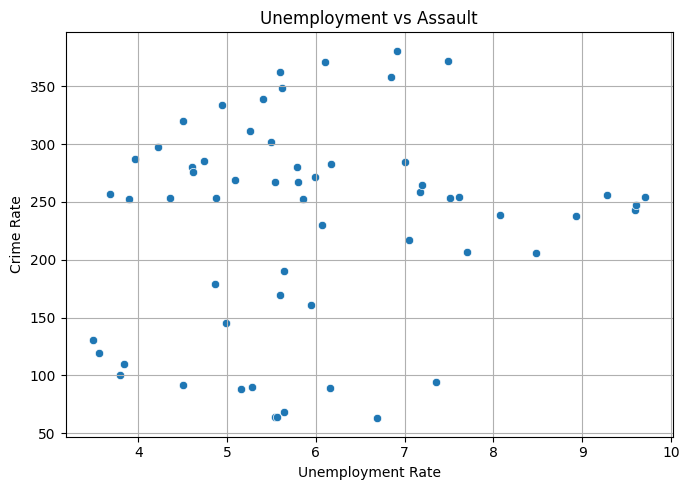

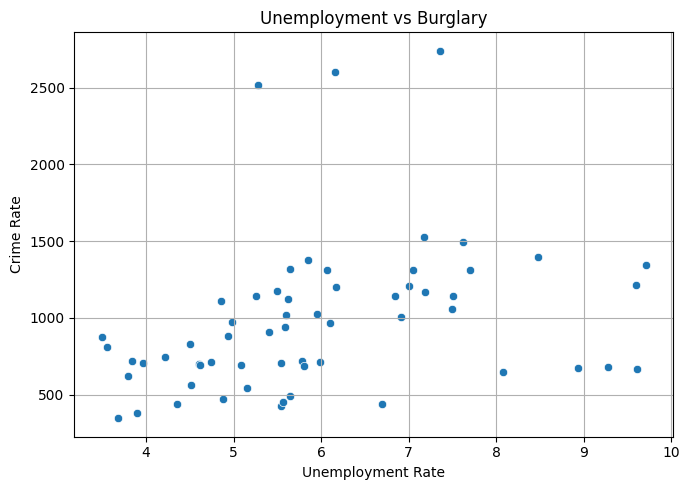

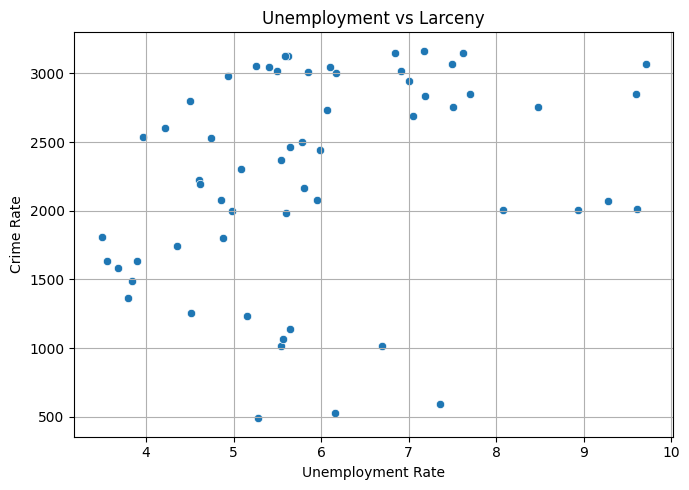

In [27]:
crime_types = [
    'TotalCrimeRate', 'Data.Rates.Violent.Murder', 'Data.Rates.Violent.Assault',
    'Data.Rates.Property.Burglary', 'Data.Rates.Property.Larceny'
]

for crime in crime_types:
    plt.figure(figsize=(7, 5))
    sns.scatterplot(x=merged_df['UnemploymentRate'], y=merged_df[crime])
    plt.title(f"Unemployment vs {crime.split('.')[-1]}")
    plt.xlabel("Unemployment Rate")
    plt.ylabel("Crime Rate")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 7. Summary of Exploratory Data Analysis (EDA)

This exploratory data analysis investigated the relationship between unemployment rates and various crime rates across the United States over several decades. By merging two datasets — one on unemployment and one on state-level crime statistics — we were able to compute annual averages and trends for meaningful comparison.


- Data Cleaning and Preprocessing:

- Parsed dates and extracted yearly unemployment averages.

- Aggregated crime data from state-level to national yearly averages.

- Created a composite TotalCrimeRate metric.

Descriptive Statistics:

- Summary stats showed notable variability and skewness in both unemployment and crime rates.

- Year-over-year percentage changes revealed spikes and economic-crime shifts during certain decades.

Correlation Analysis:

- Heatmap indicated moderate positive correlations between unemployment and certain crime types like larceny, robbery, and assault.

- Year-over-year changes in unemployment and crime showed weak correlations, suggesting long-term trends are more informative than short-term shocks.

Visualizations:

- Line plots demonstrated how both unemployment and crime evolved over time — crime rose significantly in the '70s–'90s and declined afterward, while unemployment followed economic cycles.

- Boxplots revealed a wide spread in crime compared to relatively tighter variation in unemployment.

- Scatterplots highlighted moderate upward trends between unemployment and crimes like assault and larceny, hinting at potential economic motivation behind these offenses.

- Separate trend lines for violent and property crimes helped distinguish differing patterns in types of crime over the decades.
